In [193]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import dataset  
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [194]:
train_data = datasets.FashionMNIST(root='Data', 
                                   train=True, 
                                   transform=torchvision.transforms.ToTensor(), # convert PIL images to torch tensors
                                   target_transform=None, # to transform the label or target
                                   download=True)

test_data = datasets.FashionMNIST(root='Data',
                                  train=False, # 'false' will download the test data 
                                  transform=torchvision.transforms.ToTensor(), # convert PIL images to torch tensors
                                  target_transform=None,
                                  download=True)

In [195]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [196]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [197]:
image, label = test_data[0]

In [198]:
print(f"Shape of the Image is {image.shape}") # C x H x W (color channels, height, width)
print(f"label value: {label}")

Shape of the Image is torch.Size([1, 28, 28])
label value: 9


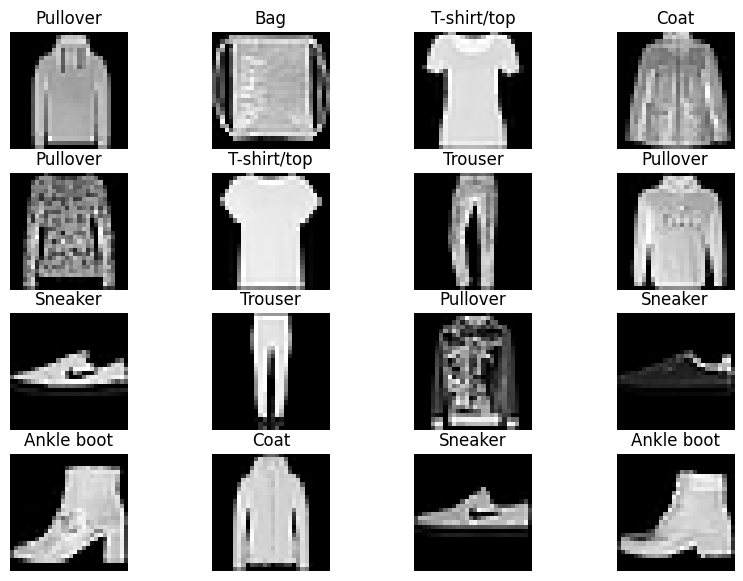

In [199]:
# Visualize the dataset

fig = plt.figure(figsize=(10,7))
row, col = 4, 4
for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap='gray') # squeeze is required to reduce img size from CxHxW to HxW, as matplotlib expects img in HxWXC or HxW
    plt.title(class_names[label])
    plt.axis(False)


In [200]:
# Create an Iterable for our dataset: Dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)}, with batch size of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)}, with batch size of {BATCH_SIZE}")

Length of train_dataloader: 1875, with batch size of 32
Length of test_dataloader: 313, with batch size of 32


train_feature shape: torch.Size([32, 1, 28, 28])
train_label shape: torch.Size([32])


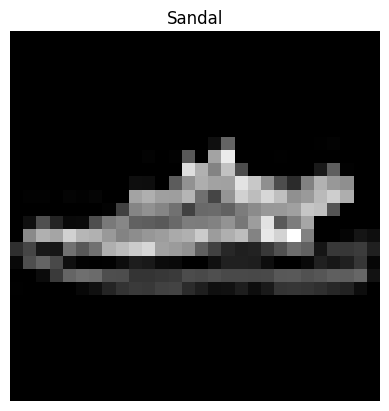

In [201]:
train_feature, train_label = next(iter(train_dataloader))
print(f"train_feature shape: {train_feature.shape}") # BxCxHxW [batch size, color channels, height, width]
print(f"train_label shape: {train_label.shape}")
random_idx = np.random.randint(0, len(train_label), 1)
img = train_feature[0].squeeze() # cause CxHxW is not the format for matplotlib 
plt.imshow(img, cmap='gray')
plt.axis(False)
plt.title(class_names[train_label[0]])
plt.show()

In [202]:
train_feature[0].squeeze().shape, train_feature[0].shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

In [203]:
# Flatten layer
flatten = nn.Flatten()

# create a dummy img shape matrix
img = torch.rand((1, 28, 28))

# Flatten it using the flatten layer
flatten_img = flatten(img)

# Print out the shapes
print(f"shape of the img before flatten: {img.shape}")
print(f"shape of the img after flatten: {flatten_img.shape}")

shape of the img before flatten: torch.Size([1, 28, 28])
shape of the img after flatten: torch.Size([1, 784])


In [204]:
# Create  a basic model

class CnnModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.nnLayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnLayers(x)

In [205]:
model = CnnModel(input_dim=784, hidden_dim=10, output_dim=len(class_names)) # 784 cause 28*28 is the dim of the input image 

In [206]:
model(train_feature[0])

tensor([[-0.2709, -0.0220,  0.0932,  0.2313, -0.0404, -0.2446,  0.1018,  0.2036,
         -0.0631,  0.4520]], grad_fn=<AddmmBackward0>)

In [207]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [208]:
(y_pred.argmax(dim=1)).shape

torch.Size([32])

In [209]:
(y_pred.argmax(dim=1))

tensor([7, 9, 0, 5, 1, 4, 1, 1, 7, 9, 0, 0, 3, 9, 8, 3, 4, 7, 0, 2, 3, 8, 7, 2,
        5, 0, 1, 9, 2, 9, 9, 3], device='cuda:0')

In [210]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CnnModel(
  (nnLayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [211]:
# Train and Test the data
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
    batch_train_loss = 0
    # X, y --> img, label
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        model.train()
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train) # argmax is to select the class that has the highest Logit value
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        batch_train_loss += train_loss

    batch_test_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_data):
            X_test = X_train.to(device)
            y_test = y_train.to(device)
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            batch_test_loss += test_loss

    print(f"Epoch: {epoch} | train loss: {batch_train_loss} | test loss: {batch_test_loss}")

 10%|█         | 1/10 [00:12<01:52, 12.48s/it]

Epoch: 0 | train loss: 1113.391845703125 | test loss: 3439.93896484375


 20%|██        | 2/10 [00:24<01:39, 12.49s/it]

Epoch: 1 | train loss: 894.52978515625 | test loss: 2990.889892578125


 30%|███       | 3/10 [00:37<01:26, 12.40s/it]

Epoch: 2 | train loss: 851.7308349609375 | test loss: 3028.962646484375


 40%|████      | 4/10 [00:49<01:13, 12.21s/it]

Epoch: 3 | train loss: 832.5440673828125 | test loss: 2629.335205078125


 50%|█████     | 5/10 [01:01<01:00, 12.19s/it]

Epoch: 4 | train loss: 816.3348999023438 | test loss: 2412.0478515625


 60%|██████    | 6/10 [01:13<00:48, 12.11s/it]

Epoch: 5 | train loss: 805.7254028320312 | test loss: 2566.11279296875


 70%|███████   | 7/10 [01:25<00:36, 12.13s/it]

Epoch: 6 | train loss: 797.8419189453125 | test loss: 4231.15478515625


 80%|████████  | 8/10 [01:37<00:24, 12.17s/it]

Epoch: 7 | train loss: 792.8856201171875 | test loss: 3098.147705078125


 90%|█████████ | 9/10 [01:50<00:12, 12.32s/it]

Epoch: 8 | train loss: 785.4161987304688 | test loss: 2915.722900390625


100%|██████████| 10/10 [02:02<00:00, 12.23s/it]

Epoch: 9 | train loss: 783.3069458007812 | test loss: 1671.0545654296875


Text(0.5, 1.0, 'Dress')

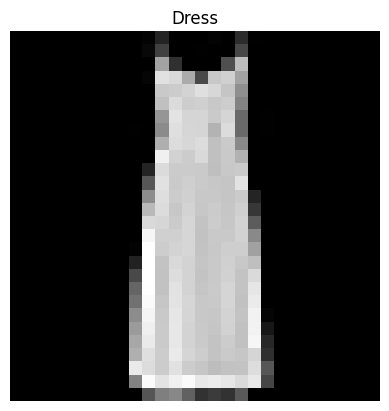

In [254]:
test_img, test_label = next(iter(test_dataloader))
random_idx = np.random.randint(0, len(test_img), 1)
plt.imshow(test_img[random_idx].squeeze(), cmap='gray')
plt.axis(False)
plt.title(class_names[test_label[random_idx]])


In [255]:
with torch.inference_mode():
    pred = model(test_img[random_idx].to(device))

print(f"Predicted class: {class_names[pred.argmax()]}")

Predicted class: Dress
